In [1]:
import osmnx as ox
import networkx as nx
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

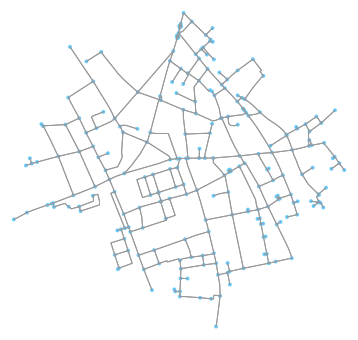

In [2]:
B = ox.graph_from_point((51.5222686,-0.1106871), network_type='walk', 
                        distance=500, distance_type ='network')
fig, ax = ox.plot_graph(B)

In [3]:

url = ox.request_url(lat,lon,50)
ox.match_request(url)

NameError: name 'lat' is not defined

In [ ]:
address = '6 Vine Hill, London'
G = ox.graph_from_address(address, network_type='walk', 
                        distance=5000, distance_type ='network')
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph(G_proj)

In [ ]:
A = nx.adjacency_matrix(B)
print(A.todense())

In [ ]:
nx.degree_histogram(G)

In [ ]:
B.edges

In [ ]:
print(nx.shortest_path_length(B, source=415774755, target=237900))

In [ ]:
len(B.nodes)

In [ ]:
c = nx.attr_matrix(B)

In [ ]:
c[0][1,1]

In [ ]:
ox.stats.basic_stats(B)

In [ ]:
C = ox.core.add_edge_lengths(B)

In [ ]:
type(C.edges)

In [ ]:
list(C.edges())

In [ ]:
# access information about edge, including ID, location, length (in m), etc
# third index accounts for multiple edges between the same nodes - basically all 0 for this case
print(C.edges[5562142702, 18692415, 0])
print(C.edges[5562142702, 18692415, 0]['length'])

In [ ]:
print(C.nodes[415774755])

In [ ]:
# create route from node ids and visualize
orig_node = 5562142702
dest_node = 107894
route = nx.shortest_path(B, orig_node, dest_node, weight='length')
route2 = nx.shortest_path(B, orig_node, 1697813677, weight='length')

In [ ]:
route
# looks like route is just a list of nodes

In [ ]:
fig, ax = ox.plot_graph_route(B, [route, route2], node_size=0)

In [ ]:
# for every edge, increase the "visits" iterator by one if it has been visited by a GPX track
B.edges[5562142702,109939,0]['visits'] = 1

In [ ]:
B.edges[5562142702,109939,0]

In [ ]:
B.edges[5562142702,109939,0]['visits'] +=1

In [ ]:
B.edges[(5562142702,109939,0)]

In [ ]:
r = [[],34]

In [ ]:
type(r)

In [ ]:
# determine if list of lists
any(isinstance(el, list) for el in r)

In [ ]:
for i in range(0):
    print(i)

In [ ]:
len(r)

In [ ]:
k = []
n = [k]
n

In [ ]:
gpx_file = open('alltrax/20170914094943.gpx', 'r')
ox.parse_gpx('alltrax/20170914094943.gpx')

In [ ]:
type(gpx_file)

In [ ]:
import gpxpy
import datetime

In [ ]:
gpx = gpxpy.parse(gpx_file)

In [ ]:
gpx

In [ ]:
lat = []
lon = []
time = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lat.append(point.latitude)
            lon.append(point.longitude)
            time.append(point.time)
            

In [ ]:
datetime.timestamp(point.time)

In [ ]:
b = []
b.append('yes')

In [ ]:
b

In [ ]:
b.append(5)
b

In [ ]:
def request_url(lat, lon, maxpoints=len(lat)):
    """
    Convert lat and lon to a url query string.

    Converts lat and lon to a query string using osrm router.

    Parameters
    ----------
    lat : list
        ordered list of all latitudes
    lon : list
        ordered list of all longitudes
    maxpoints: int
        maximum number of points to be included, defaults to all

    Returns
    -------
    url : string
        query url to be used for osrm routing
    """
    # how many points should we include? can we include all of them?
    baseurl = 'http://router.project-osrm.org/match/v1/walking/'
    options = '?overview=full&annotations=true'

    coords = ''
    # pick every nth coordinate up to maxpoints
    npoints = len(lat) % maxpoints
    point_interval = int(len(lat)/max(npoints,1))
    for i in range(npoints):
        coords += str(lon[i*point_interval]) + ',' + str(lat[i*point_interval]) + ';'

    return baseurl + coords[:-1] + options

In [ ]:
def match_request(url, pause_duration=None, timeout=180, error_pause_duration=None):
    """
    Send a request to the Overpass API via HTTP POST and return the JSON
    response.

    Parameters
    ----------
    data : dict or OrderedDict
        key-value pairs of parameters to post to the API
    pause_duration : int
        how long to pause in seconds before requests, if None, will query API
        status endpoint to find when next slot is available
    timeout : int
        the timeout interval for the requests library
    error_pause_duration : int
        how long to pause in seconds before re-trying requests if error

    Returns
    -------
    dict
    """

    # define the Overpass API URL, then construct a GET-style URL as a string to
    # hash to look up/save to cache
    prepared_url = requests.Request('GET', url).prepare().url
    cached_response_json = get_from_cache(prepared_url)

    if cached_response_json is not None:
        # found this request in the cache, just return it instead of making a
        # new HTTP call
        return cached_response_json

    else:
        # if this URL is not already in the cache, pause, then request it
        if pause_duration is None:
            this_pause_duration = get_pause_duration()
        log('Pausing {:,.2f} seconds before making API GET request'.format(this_pause_duration))
        time.sleep(this_pause_duration)
        start_time = time.time()
        log('Posting to {} with timeout={}, "{}"'.format(url, timeout, data))
        response = requests.post(url, data=data, timeout=timeout, headers=get_http_headers())

        # get the response size and the domain, log result
        size_kb = len(response.content) / 1000.
        domain = re.findall(r'//(?s)(.*?)/', url)[0]
        log('Downloaded {:,.1f}KB from {} in {:,.2f} seconds'.format(size_kb, domain, time.time()-start_time))

        try:
            response_json = response.json()
            if 'remark' in response_json:
                log('Server remark: "{}"'.format(response_json['remark'], level=lg.WARNING))
            save_to_cache(prepared_url, response_json)
        except Exception:
            #429 is 'too many requests' and 504 is 'gateway timeout' from server
            # overload - handle these errors by recursively calling
            # overpass_request until we get a valid response
            if response.status_code in [429, 504]:
                # pause for error_pause_duration seconds before re-trying request
                if error_pause_duration is None:
                    error_pause_duration = get_pause_duration()
                log('Server at {} returned status code {} and no JSON data. Re-trying request in {:.2f} seconds.'.format(domain,
                                                                                                                         response.status_code,
                                                                                                                         error_pause_duration),
                                                                                                                         level=lg.WARNING)
                time.sleep(error_pause_duration)
                response_json = overpass_request(data=data, pause_duration=pause_duration, timeout=timeout)

            # else, this was an unhandled status_code, throw an exception
            else:
                log('Server at {} returned status code {} and no JSON data'.format(domain, response.status_code), level=lg.ERROR)
                raise Exception('Server returned no JSON data.\n{} {}\n{}'.format(response, response.reason, response.text))

            return response_json

In [ ]:
url = ox.gpx.request_url(lat,lon,50)
ox.gpx.match_request(url)

In [ ]:
import requests
import json
response = requests.get(url)
rdict = response.json()
rdict["matchings"][1]['legs']

In [ ]:
rdict["matchings"][0]['legs']

In [ ]:
response.text

In [ ]:
int(len(lat)/m)

In [ ]:
freq = {(1,2,0):5}

In [ ]:
key = (1,4,0)
if key in freq:
    freq[key] += 1
else:
    freq[key] = 1

In [ ]:
freq

In [ ]:
import os

In [ ]:
os.fullpath.listdir("/Users/heidihurst/Documents/UK/ucl-gis/ucl_msc/term2/networks/alltrax")

In [ ]:
# identify edges adjacent to node
import osmnx as ox
import networkx as nx
B = ox.graph_from_point((51.5222686,-0.1106871), network_type='walk', 
                        distance=500, distance_type ='network')
fig, ax = ox.plot_graph(B)
type(B)

In [ ]:
B.node[415774755]

In [ ]:
type(ox.get_nearest_node(B, (51.5208513,-0.1148912)))

In [ ]:
bob = nx.all_neighbors(B, 5484235162)
edges = [(5484235162, neighbor, 0) for neighbor in nx.all_neighbors(B, 5484235162)]
print(edges)
print(B[5484235164][5484235162][0])
print(B[5484235162][5484235164][0]['length'])

## Path Algorithm
#### Part one: out
Steps:
- identify current node
- evaluate all potential edges
- select next node based on edges
    - edge evaluation functions
- set next node as current node
- increment run length by current edge length
- repeat
- end condition: run length reaches certain threshold

#### Part two: back
- Steps

In [ ]:
next_outbound_node(B,5484235162)

In [ ]:
def test_function(x, function = lambda x: min(x)):
    return function(x)

In [ ]:
test_function([5,1,4], function = lambda k: max(k))

In [ ]:
def evaluate_edges(graph, route, freq={}, eval_function=lambda x: x['length'], *args, **kwargs):
    # get all neighbors of current node
    current_node = route[-1]
    # edges = [(current_node, neighbor, 0) for neighbor in nx.all_neighbors(graph, current_node)]

    # get all neighbors
    neighbors = [neighbor for neighbor in nx.all_neighbors(graph, current_node)]
    neighbors = list(set(neighbors))
    # ensure that you cannot revisit the previous node
    #print(neighbors)
    if len(route) > 1:
        previous_node = route[-2]
        #print(previous_node)
        neighbors = [x for x in neighbors if x != previous_node]
            
    #print(neighbors)
    
    # remove neighbor nodes that are dead ends
    for neighbor in neighbors:
        nneighbor = [neighbor for neighbor in nx.all_neighbors(graph, neighbor)]
        if len(set(nneighbor)) == 1:
            neighbors.remove(neighbor)

    # initialize suitability list
    suitability = []

    # for each neighbor, query edge attributes
    for neighbor in neighbors:
        # initialize attribute dictionary
        attributes = dict()
        # road length
        attributes['length'] = graph[current_node][neighbor][0]['length']

        # frequency
        attributes['frequency'] = 0
        if (current_node, neighbor, 0) in freq.keys():
            attributes['frequency'] += freq[(current_node, neighbor, 0)]
        elif (neighbor, current_node, 0) in freq.keys():
            attributes['frequency'] += freq[(neighbor, current_node, 0)]

        # bearings
        if len(route) > 1:
            attributes['previous_bearing'] = graph[previous_node][current_node][0]['bearing']
        else:
            attributes['previous_bearing'] = None
        attributes['next_bearing'] = graph[current_node][neighbor][0]['bearing']
        #attributes['home_bearing'] =

        # has it been traveled before?
        attributes['traveled'] = (current_node, neighbor) in zip(route, route[1:])
        
        # append suitability to list
        suitability.append(eval_function(attributes))

        # select node with optimized suitability
        next_node = neighbors[suitability.index(min(suitability))]
        
        print(attributes)

    return next_node

def inbound_optimization(attributes={}):
    
    suitability = attributes['traveled'] * attributes['length']

    return suitability

def next_inbound_node(graph, route, freq={}, *args, **kwargs):
    # call evaluate edges with inbound node parameters?
    next_node = evaluate_edges(graph=graph, route=route, freq=freq, eval_function=inbound_optimization)

    return next_node


In [ ]:
ox.add_edge_bearings(B)
B[5484235162][5484235164][0]['bearing']
#evaluate_edges(B,[5484235162,5484235164])

In [ ]:
next_inbound_node(B,[5484235162,5484235164])

In [ ]:
import time
def generate_route(lat, lon, goal_length, tolerance=0.5, length_unit='km', freq={}, *args, **kwargs):
    # 
    start_time = time.time()
    
    # convert km to meters
    if length_unit == 'km':
        goal_length = 1000 * goal_length
        tolerance = 1000 * tolerance

    # get graph of area
    # TODO: modify to load from point id?
    streets = ox.graph_from_point((lat, lon), distance=goal_length/1.75)
    # add length attribute to all nodes
    ox.add_edge_lengths(streets)
    ox.add_edge_bearings(streets)
    # get start node
    start_node = ox.get_nearest_node(streets, (lat, lon))

    # setup
    route_length = 0
    route = [start_node]

    # outbound portion
#    while route_length < goal_length/2:
#        # select next node based on optimization function
#        next_node = next_outbound_node(streets, route, freq, *args, **kwargs)
#        # augment route length
#        route_length += streets[route[-1]][next_node]['length']
#        # add new node to route
#        route.append(next_node)

    # inbound portion (return)
#    while route[-1] != start_node and route_length < goal_length - tolerance:
    i = 2
    while route_length < goal_length - tolerance:
        # ox.log('Searching for node number {} from current node id {}'.format(i, route[-1]))
        print(route)
        i += 1
        # select node based on inbound optimization function
        next_node = next_inbound_node(streets, route, freq, *args, **kwargs)
        # augment route length
        route_length += streets[route[-1]][next_node][0]['length']
        # add new node to route
        route.append(next_node)

        # prevent function for running forever
        if route_length > goal_length + tolerance:
            ox.log('Unable to find route of length {} {} for start node {} with tolerance {}.  Process took {:.2f} seconds'.format(goal_length,
                                                                                                  length_unit,
                                                                                                  start_node,
                                                                                                  tolerance,
                                                                                                                          time.time()-start_time),
                level=lg.WARNING)
            route = [start_node]
            break

    ox.log('Found route of length {:.0f}m in {:.2f} seconds'.format(route_length, time.time()-start_time))
    return route

In [ ]:
newroute = ox.generate_route(51.5208513, -0.1148912, 1)

In [ ]:
newroute

In [ ]:
test_streets = ox.graph_from_point((51.5208513, -0.1148912), distance=400)
fig, ax = ox.plot_graph_route(test_streets, newroute, node_size=0)

In [ ]:
streets = ox.graph_from_point((51.5208513, -0.1148912), distance=2500)
    # add length attribute to all nodes
ox.add_edge_lengths(streets)
ox.add_edge_bearings(streets)

streets[415774755][251347820][0]

In [ ]:
b = ['a','b']
print(b)
b.remove('b')
print(b)

In [ ]:
nx.degree(streets,415775189)

In [ ]:
test = [415774755, 415774877, 415775189, 415774877, 415775189, 415774755, 415774877]
[x for x in test if x != 415774877]
search(test,[415774755, 415774877])

In [ ]:
streets[415775463]

In [ ]:
for neighbor in nx.all_neighbors(streets, 415775463):
    print(neighbor)
print(nx.degree(streets,415775463))

In [ ]:
for neighbor in nx.all_neighbors(streets, 415775189):
    print(neighbor)
print(nx.degree(streets,415775189))

In [ ]:
set(test)

In [ ]:
list(set(test))

In [ ]:
(415774755, 1) in zip(test, test[1:])

In [ ]:
test = [1] * 10
print('testing {}'.format(test))

|Attempting|A|Table|
|----------|:----:|----|
|hello there| ![Image from desktop](images/IMG_3108.jpg)| `also`|

![Image from desktop](IMG_3108.jpg)

In [ ]:
nx.shortest_path_length(streets, 415774755, 5484235162)

In [ ]:
nx.shortest_path(streets, 415774755, 5484235162)

In [ ]:
~True

In [ ]:
False * False

In [ ]:
# troubleshooting: node has no suitability
streets_freq = ox.graph_from_point((51.5223019,-0.1107007), distance=1000/1.75)
streets.nodes[1159495478]
# what are its neighbors like?
for neighbor in nx.all_neighbors(streets, 1159495478):
    print(neighbor)

In [ ]:
n = []
for neighbor in nx.all_neighbors(streets, 1159495421):
    n.append(neighbor)

In [ ]:
n

In [ ]:
len(set(n))

In [ ]:
len(n)

In [ ]:
node = 1159495421
neighbors = []
for neighbor in nx.all_neighbors(streets, node):
    neighbors.append(neighbor)

In [ ]:
print(neighbors)
neighbors = list(set(neighbors))
print(neighbors)

In [ ]:
for neighbor in neighbors:
    print('------')
    print(neighbors)
    nneighbor = [neighbor for neighbor in nx.all_neighbors(streets, neighbor)]
    print(nneighbor)
    if len(set(nneighbor)) == 1:
        print("removing {} from set of neighbors {}".format(neighbor, nneighbor))
        neighbors = [x for x in neighbors if x != nneighbor]
    print(neighbors)

In [ ]:
# where is the problem
problem_route = [11546253, 18670874,25497664,25497878,877245092,1159495421]
streets = ox.graph_from_point((51.5223019,-0.1107007), distance=1000/1.75)
fig, ax = ox.plot_graph_route(streets, problem_route, node_size=0)

In [ ]:
type(2) == int

In [ ]:
b = [1,2,3,4,5,6,7,8]
b.pop(1)
b

In [ ]:
b.pop([2,3])

In [ ]:
b.extend([2,3])
b

In [ ]:
b = []
b.extend([2,3])

In [ ]:
0 + None

In [ ]:
b.extend(5)

In [ ]:
streets = ox.graph_from_point((51.5223019,-0.1107007), distance=1000/1.75)

In [ ]:
streets.nodes

In [ ]:
nx.shortest_path_length(streets, 13799043, 3085109082, 'length')

In [ ]:
nx.shortest_path_length(streets, 13799043, 3085109082)

In [ ]:
0 < 5 < 10

## Troubleshooting


In [ ]:
import osmnx as ox
import networkx as nx
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

In [ ]:
# read in gpx, view resultant frequency dictionary
folder = "/Users/heidihurst/Documents/UK/ucl-gis/ucl_msc/term2/networks/alltrax"
freq = ox.freq_from_folder(folder,npoints=250)
print(freq)

In [ ]:
# create 1 km route starting from (51.5208513, -0.1148912)
# 51.5223019,-0.1107007
newroute_freq = ox.generate_route(51.5223019,-0.1107007, 5)

In [ ]:
# visualize route overlaid on city map
streets_freq = ox.graph_from_point((51.5223019,-0.1107007), distance=5000/1.75, network_type='walk')
#fig, ax = ox.plot_graph_route(streets_freq, newroute_freq, node_size=0)

In [ ]:
newroute_freq

## Interactive Plotting
http://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Heatmap.ipynb

In [ ]:
graph_map = ox.plot_route_folium(streets_freq, newroute_freq)

In [ ]:
streets_freq.edges

In [ ]:
small_example = ox.graph_from_point((51.5223019,-0.1107007), distance=500)

In [ ]:
small_example.edges

In [ ]:
for edge in small_example.edges:
    print(edge)

In [ ]:
e1 = small_example.edges[1]

In [ ]:
small_example.edges(data='oneway', keys=False)

In [ ]:
x = [n for n in small_example.edges(data='oneway', keys=False) if not n[-1]]

In [ ]:
y = [n for n in small_example.edges(data='oneway', keys=True) if n[-1]]

In [ ]:
z = [n for n in small_example.edges(data=True, keys=True) if n[-1]]
print(z)

In [ ]:
small_example.get_edge_data(*(2228273, 110124, 0))

In [ ]:
small_example[1399290769][1953096780][0]['bearing']

In [ ]:
# add bearings
ox.add_edge_bearings(small_example)
e = small_example.out_edges(iter([1399290769]), data=True)

In [ ]:
for edge in e:
    print(edge)

In [ ]:
small_example[*(1942702258, 1942702275)]

In [ ]:
k = *(1942702258, 1942702275)

In [8]:
x = [1,2,3,4,5,6,7,8,9]
p = [n/sum(x) for n in x]

In [11]:
import numpy as np


8

In [13]:
np.random.choice(x, 1, p)[0]

5

In [14]:
range(5)

range(0, 5)

In [15]:
list(range(5))

[0, 1, 2, 3, 4]